In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

from scipy import sparse 
from scipy.stats import norm
from numpy import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
#是否读取原始数据
F_netflix_test = 'netflix_test.csv'
F_netflix_train = 'netflix_train.csv'
F_users = 'users.csv'
F_movie_titles = 'movie_titles.csv'
F_users_T = 'users_T.csv'

if os.path.exists(F_netflix_test)==False \
    or os.path.exists(F_netflix_train)==False \
    or os.path.exists(F_users)==False \
    or os.path.exists(F_movie_titles)==False \
    or os.path.exists(F_users_T)==False:
    print '从原始数据读取并处理。'
    #数据读入
    df_file_test = pd.read_csv('netflix_test.txt' , sep=' ' , header = None , names = ['UID','MID','score','date'])
    df_file_train = pd.read_csv('netflix_train.txt' , sep=' ' , header = None , names = ['UID','MID','score','date'])
    df_file_users = pd.read_csv('users.txt' , sep=' ' , header = None , names = ['UID'])

    #电影名字存在有特殊字符，单独写代码进行处理
    df_file_titles = pd.DataFrame(index = [],columns = ['YEAR','MNAME'])
    lines = [line.strip().decode('utf', 'ignore') for line in open('movie_titles.txt').readlines()]
    for line in lines:
        splstr = line.split(',')
        MID = splstr[0]
        YEAR = splstr[1]
        MNAME = line[len(MID)+len(YEAR)+2:]
        df_file_titles.loc[MID,'YEAR'] = YEAR
        df_file_titles.loc[MID,'MNAME'] = MNAME
        
    #用户INDEX与之用户ID的对应表，和df_file_users构成逆表关系，互查
    df_file_users_T = df_file_users[:]
    df_file_users_T = df_file_users_T.reset_index()
    df_file_users_T = df_file_users_T.set_index('UID')
    df_file_users_T.rename(columns = {'index':'UIDX'},inplace=True)
    
    #训练测试数据添加UIDX列保证UIDX取值范围控制再在0~9999之间
    df_file_train_UIDX = df_file_train['UID']
    df_file_test_UIDX = df_file_test['UID']
    for index in df_file_users_T.index.values:
        df_file_train_UIDX = df_file_train_UIDX.replace(index, int(df_file_users_T.loc[index,'UIDX']))
        df_file_test_UIDX = df_file_test_UIDX.replace(index, int(df_file_users_T.loc[index,'UIDX']))
    df_file_train['UIDX'] = df_file_train_UIDX
    df_file_test['UIDX'] = df_file_test_UIDX

    #训练测试数据添加MIDX列保证MIDX取值范围控制再在0~9999之间
    df_file_train['MIDX'] = df_file_train['MID'] - 1
    df_file_test['MIDX'] = df_file_test['MID'] - 1
    
    #保存
    df_file_test.to_csv(F_netflix_test)
    df_file_train.to_csv(F_netflix_train)
    df_file_users.to_csv(F_users)
    df_file_titles.to_csv(F_movie_titles)
    df_file_users_T.to_csv(F_users_T)
    
else:
    print '直接读取已有数据。'
    df_file_test = pd.read_csv(F_netflix_test)
    df_file_train = pd.read_csv(F_netflix_train)
    df_file_users = pd.read_csv(F_users)
    df_file_titles = pd.read_csv(F_movie_titles)
    df_file_users_T = pd.read_csv(F_users_T)
    
print '数据读入完成！'

直接读取已有数据。
数据读入完成！


In [3]:
#创建训练和测试矩阵
row = df_file_train['UIDX'].values
col = df_file_train['MIDX'].values
data= df_file_train['score'].values
X_train = sparse.coo_matrix((data, (row, col)), shape=(10000, 10000)).toarray()
X_train = mat(X_train)
print 'TRAIN'
print X_train

row = df_file_test['UIDX'].values
col = df_file_test['MIDX'].values
data= df_file_test['score'].values
X_test = sparse.coo_matrix((data, (row, col)), shape=(10000, 10000)).toarray()
X_test = mat(X_test)
print 'TEST'
print X_test

TRAIN
[[1 0 2 ..., 1 1 2]
 [1 0 2 ..., 1 2 1]
 [0 1 0 ..., 1 1 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
TEST
[[0 1 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [1 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [8]:
#求两个矩阵的标记矩阵
bool_train = np.sign(X_train)
bool_test = np.sign(X_test)

def get_RMSE(pre_train):
    pre_test = multiply(pre_train,bool_test)
    sub_2 = np.square(pre_test - X_test)
    RMSE = np.sqrt( sub_2.sum() / bool_test.sum() )
    return RMSE

In [9]:
all_begin = datetime.datetime.now()
#求各个列的模
mod_train = np.sqrt (multiply(X_train,X_train) * mat(np.ones((X_train.shape[0],1))))
#逐行单位化之后的向量
unit_train = np.nan_to_num(divide(X_train,mod_train))
#得到用户间cos关系矩阵
cos_train = unit_train * unit_train.T

#计算出所有预测结果
pre_train = np.nan_to_num(divide(cos_train * X_train,cos_train * bool_train))

#计算RMSE
RMSE = get_RMSE(pre_train)

all_end = datetime.datetime.now()
print 'RMSE= ' + str(RMSE)
print 'Time= ' + str(all_end - all_begin)

RMSE= 1.01910719672
Time= 0:01:21.386357


In [8]:
#Frobenius范数
def Frobenius(matrix):
    diag = np.diag(matrix)
    diag = diag * diag
    return diag.sum()

#计算J值
def get_J( U , V , ld ):
    sub = multiply( bool_train , subtract( X_train , U * V.T ) )
    step1 = np.square(Frobenius(sub)) / 2
    step2 = np.square(Frobenius(U)) * ld
    step3 = np.square(Frobenius(V)) * ld
    return step1 + step2 + step3

#求偏导数
def get_pd_U( U , V , ld ):
    return multiply( bool_train , U * V.T - X_train ) * V + 2 * ld * U

def get_pd_V( U , V , ld ):
    return multiply( bool_train , U * V.T - X_train ).T * U + 2 * ld * V

#步进后的矩阵
def get_next_U( U , V , ld , af ):
    return U - ( af * get_pd_U( U , V , ld ) )

def get_next_V( U , V , ld , af ):
    return V - ( af * get_pd_V( U , V , ld ) )

#梯度下降算法
def Gradient_Decline( k , af , ld , maxCycles ):
    #按照正态分布，随机生成U、V
    m = X_train.shape[0]
    n = X_train.shape[1]
    U = mat(np.random.normal(size=m*k)).reshape(m,k)
    V = mat(np.random.normal(size=n*k)).reshape(n,k)
    
    #记录返回结果的list
    l_idx = []
    l_J = []
    l_RMSE = []
    #最多循环次数
    for cyc in  range(maxCycles):
        U = get_next_U( U , V , ld , af )
        V = get_next_V( U , V , ld , af )
        J = get_J( U , V , ld )
        RMSE = get_RMSE(U*V.T)
        l_idx.append(cyc)
        l_J.append(J)
        l_RMSE.append(RMSE)
        #print cyc , J , RMSE
    
    return l_idx , l_J , l_RMSE

20 0.1
20 0.01
20 0.001
50 0.1
50 0.01
50 0.001


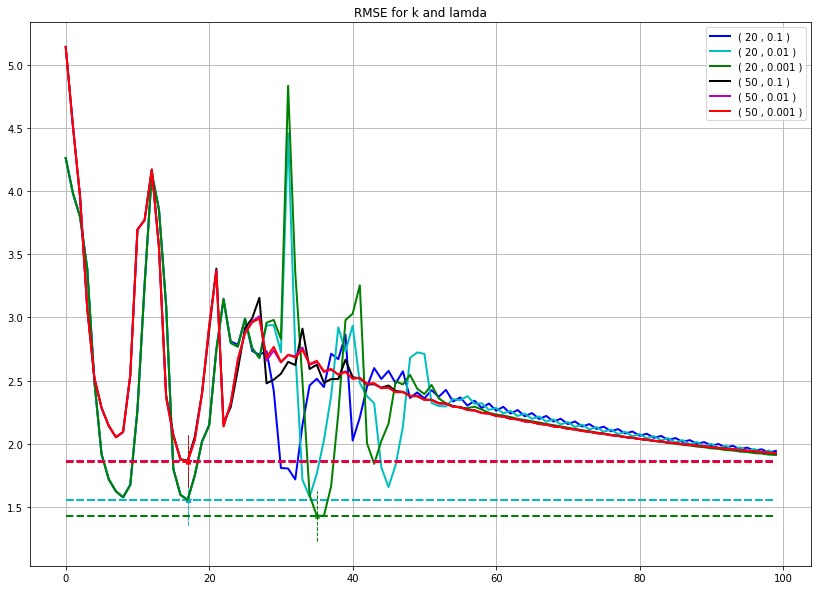

             k  lamda min RMSE   min J min RMSE idx            time
(20,0.1)    20    0.1  1.55405  996294           17  0:07:52.021163
(20,0.01)   20   0.01  1.55453  934742           17  0:07:53.132947
(20,0.001)  20  0.001  1.42824  558878           35  0:08:36.530333
(50,0.1)    50    0.1  1.86514  985719           17  0:08:52.103230
(50,0.01)   50   0.01  1.85906  983550           17  0:08:32.596872
(50,0.001)  50  0.001  1.85843  983525           17  0:08:33.036801


In [11]:
#1
maxrun = 100
af = 0.0002

report = pd.DataFrame([],columns=['k','lamda','min RMSE','min J','min RMSE idx','time'])

mcol = 'bcgkmry'
cidx = 0
plt.figure(figsize=(14,10))

for k in (20,50):
    for ld in (0.1,0.01,0.001):
        print k,ld
        #不同参数下计算梯度下降算法
        np.random.seed(k)
        tbegin = datetime.datetime.now()
        l_idx , l_J , l_RMSE = Gradient_Decline( k , af , ld ,maxrun )
        tend = datetime.datetime.now()
        
        report.loc['('+str(k)+','+str(ld)+')','k'] = k
        report.loc['('+str(k)+','+str(ld)+')','lamda'] = ld
        report.loc['('+str(k)+','+str(ld)+')','min RMSE'] = min(l_RMSE)
        report.loc['('+str(k)+','+str(ld)+')','min J'] = min(l_J)
        report.loc['('+str(k)+','+str(ld)+')','min RMSE idx'] = l_RMSE.index(min(l_RMSE))
        report.loc['('+str(k)+','+str(ld)+')','time'] = str(tend - tbegin)
        #可视化显示一下结果
        plt.plot( l_idx , l_RMSE , mcol[cidx]+'-' , linewidth = 2 , label='( '+ str(k) + ' , ' + str(ld) +' )' )
        plt.plot( (min(l_idx),max(l_idx)) , (min(l_RMSE),min(l_RMSE)) , mcol[cidx]+'--' , linewidth = 2 )
        plt.plot( l_RMSE.index(min(l_RMSE)) , min(l_RMSE) , mcol[cidx]+'*' , linewidth = 2 )
        plt.plot( (l_RMSE.index(min(l_RMSE)),l_RMSE.index(min(l_RMSE))) , (min(l_RMSE)-0.2,min(l_RMSE)+0.2) , mcol[cidx]+'--' , linewidth = 1 )
        cidx += 1

plt.title('RMSE for k and lamda')
plt.grid( True )
plt.legend()
plt.show()

print report

20 0.1
20 0.01
20 0.001
50 0.1
50 0.01
50 0.001


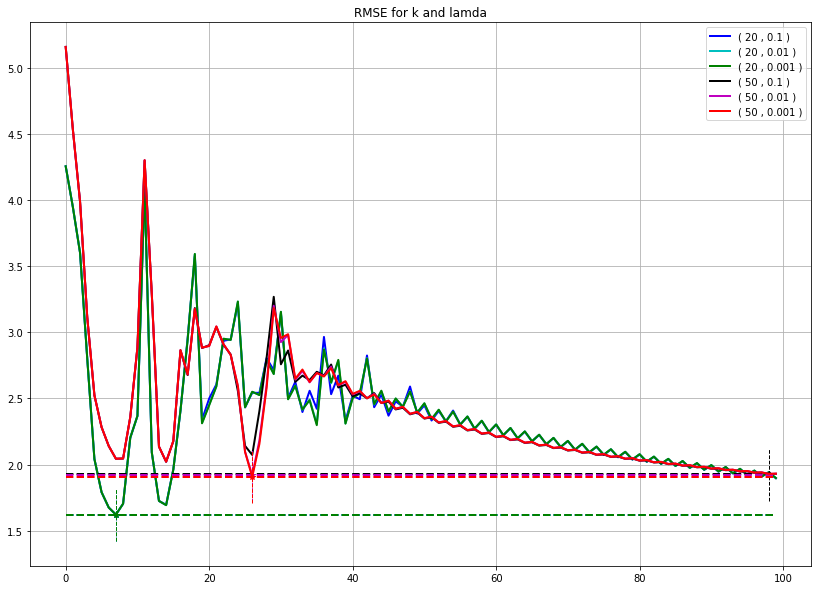

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.62166  1.13965e+06            7  0:07:47.954479
(20,0.01)   20   0.01  1.62196  1.13675e+06            7  0:07:47.671883
(20,0.001)  20  0.001  1.62199  1.13711e+06            7  0:08:31.639258
(50,0.1)    50    0.1   1.9279  1.07954e+06           98  0:10:11.074415
(50,0.01)   50   0.01  1.91963  1.08646e+06           26  0:10:09.856789
(50,0.001)  50  0.001   1.9065  1.08541e+06           26  0:10:05.031589


In [13]:
#2
maxrun = 100
af = 0.0002

report = pd.DataFrame([],columns=['k','lamda','min RMSE','min J','min RMSE idx','time'])

mcol = 'bcgkmry'
cidx = 0
plt.figure(figsize=(14,10))

for k in (20,50):
    for ld in (0.1,0.01,0.001):
        print k,ld
        #不同参数下计算梯度下降算法
        np.random.seed(k*20)
        tbegin = datetime.datetime.now()
        l_idx , l_J , l_RMSE = Gradient_Decline( X_train , k , af , ld ,maxrun )
        tend = datetime.datetime.now()
        
        report.loc['('+str(k)+','+str(ld)+')','k'] = k
        report.loc['('+str(k)+','+str(ld)+')','lamda'] = ld
        report.loc['('+str(k)+','+str(ld)+')','min RMSE'] = min(l_RMSE)
        report.loc['('+str(k)+','+str(ld)+')','min J'] = min(l_J)
        report.loc['('+str(k)+','+str(ld)+')','min RMSE idx'] = l_RMSE.index(min(l_RMSE))
        report.loc['('+str(k)+','+str(ld)+')','time'] = str(tend - tbegin)
        #可视化显示一下结果
        plt.plot( l_idx , l_RMSE , mcol[cidx]+'-' , linewidth = 2 , label='( '+ str(k) + ' , ' + str(ld) +' )' )
        plt.plot( (min(l_idx),max(l_idx)) , (min(l_RMSE),min(l_RMSE)) , mcol[cidx]+'--' , linewidth = 2 )
        plt.plot( l_RMSE.index(min(l_RMSE)) , min(l_RMSE) , mcol[cidx]+'*' , linewidth = 2 )
        plt.plot( (l_RMSE.index(min(l_RMSE)),l_RMSE.index(min(l_RMSE))) , (min(l_RMSE)-0.2,min(l_RMSE)+0.2) , mcol[cidx]+'--' , linewidth = 1 )
        cidx += 1

plt.title('RMSE for k and lamda')
plt.grid( True )
plt.legend()
plt.show()

print report

20 0.1
20 0.01
20 0.001
50 0.1
50 0.01
50 0.001


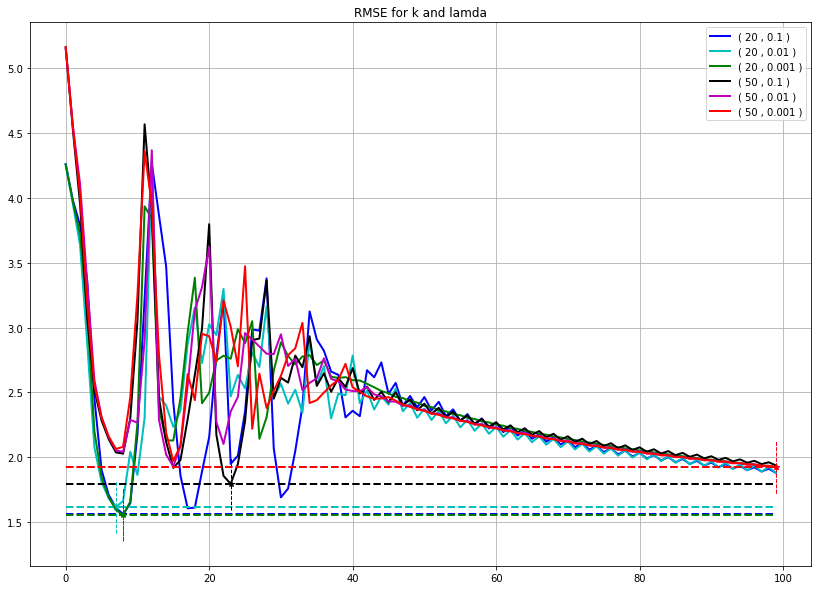

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  1.55921   1.1758e+06            8  0:07:44.444450
(20,0.01)   20   0.01  1.61488  1.05521e+06            7  0:07:49.622358
(20,0.001)  20  0.001  1.55229  1.14195e+06            8  0:07:49.855478
(50,0.1)    50    0.1  1.79382       943208           23  0:08:31.902991
(50,0.01)   50   0.01  1.92163       798892           99  0:11:14.781615
(50,0.001)  50  0.001  1.92363       790471           99  0:12:41.999810


In [11]:
maxrun = 100
af = 0.0002

report = pd.DataFrame([],columns=['k','lamda','min RMSE','min J','min RMSE idx','time'])

mcol = 'bcgkmry'
cidx = 0
plt.figure(figsize=(14,10))

for k in (20,50):
    for ld in (0.1,0.01,0.001):
        print k,ld
        #不同参数下计算梯度下降算法
        tbegin = datetime.datetime.now()
        l_idx , l_J , l_RMSE = Gradient_Decline( X_train , k , af , ld ,maxrun )
        tend = datetime.datetime.now()
        
        report.loc['('+str(k)+','+str(ld)+')','k'] = k
        report.loc['('+str(k)+','+str(ld)+')','lamda'] = ld
        report.loc['('+str(k)+','+str(ld)+')','min RMSE'] = min(l_RMSE)
        report.loc['('+str(k)+','+str(ld)+')','min J'] = min(l_J)
        report.loc['('+str(k)+','+str(ld)+')','min RMSE idx'] = l_RMSE.index(min(l_RMSE))
        report.loc['('+str(k)+','+str(ld)+')','time'] = str(tend - tbegin)
        #可视化显示一下结果
        plt.plot( l_idx , l_RMSE , mcol[cidx]+'-' , linewidth = 2 , label='( '+ str(k) + ' , ' + str(ld) +' )' )
        plt.plot( (min(l_idx),max(l_idx)) , (min(l_RMSE),min(l_RMSE)) , mcol[cidx]+'--' , linewidth = 2 )
        plt.plot( l_RMSE.index(min(l_RMSE)) , min(l_RMSE) , mcol[cidx]+'*' , linewidth = 2 )
        plt.plot( (l_RMSE.index(min(l_RMSE)),l_RMSE.index(min(l_RMSE))) , (min(l_RMSE)-0.2,min(l_RMSE)+0.2) , mcol[cidx]+'--' , linewidth = 1 )
        cidx += 1

plt.title('RMSE for k and lamda')
plt.grid( True )
plt.legend()
plt.show()

print report

20 0.1
20 0.01
20 0.001
50 0.1
50 0.01
50 0.001


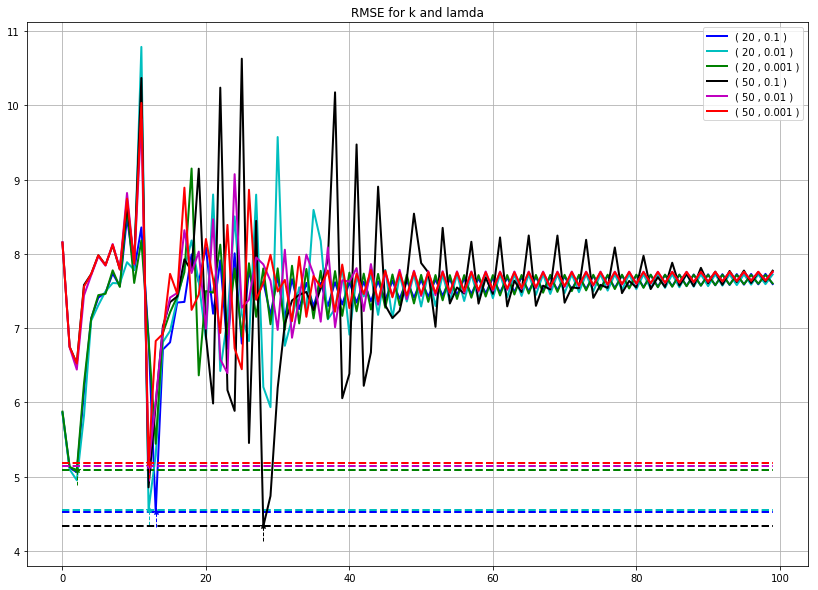

             k  lamda min RMSE        min J min RMSE idx            time
(20,0.1)    20    0.1  4.52233   1.0227e+06           13  0:07:58.549767
(20,0.01)   20   0.01  4.55284       733841           12  0:08:02.487640
(20,0.001)  20  0.001  5.08999  1.10057e+06            2  0:08:49.835470
(50,0.1)    50    0.1  4.33218       688159           28  0:10:23.949864
(50,0.01)   50   0.01  5.14244  1.01811e+06           12  0:10:24.482190
(50,0.001)  50  0.001  5.18753  1.05285e+06           12  0:09:42.855016


In [36]:
maxrun = 100
af = 0.0002

report = pd.DataFrame([],columns=['k','lamda','min RMSE','min J','min RMSE idx','time'])

mcol = 'bcgkmry'
cidx = 0
plt.figure(figsize=(14,10))

for k in (20,50):
    for ld in (0.1,0.01,0.001):
        print k,ld
        #不同参数下计算梯度下降算法
        tbegin = datetime.datetime.now()
        l_idx , l_J , l_RMSE = Gradient_Decline( X_train , k , af , ld ,maxrun )
        tend = datetime.datetime.now()
        
        report.loc['('+str(k)+','+str(ld)+')','k'] = k
        report.loc['('+str(k)+','+str(ld)+')','lamda'] = ld
        report.loc['('+str(k)+','+str(ld)+')','min RMSE'] = min(l_RMSE)
        report.loc['('+str(k)+','+str(ld)+')','min J'] = min(l_J)
        report.loc['('+str(k)+','+str(ld)+')','min RMSE idx'] = l_RMSE.index(min(l_RMSE))
        report.loc['('+str(k)+','+str(ld)+')','time'] = str(tend - tbegin)
        #可视化显示一下结果
        plt.plot( l_idx , l_RMSE , mcol[cidx]+'-' , linewidth = 2 , label='( '+ str(k) + ' , ' + str(ld) +' )' )
        plt.plot( (min(l_idx),max(l_idx)) , (min(l_RMSE),min(l_RMSE)) , mcol[cidx]+'--' , linewidth = 2 )
        plt.plot( l_RMSE.index(min(l_RMSE)) , min(l_RMSE) , mcol[cidx]+'*' , linewidth = 2 )
        plt.plot( (l_RMSE.index(min(l_RMSE)),l_RMSE.index(min(l_RMSE))) , (min(l_RMSE)-0.2,min(l_RMSE)+0.2) , mcol[cidx]+'--' , linewidth = 1 )
        cidx += 1

plt.title('RMSE for k and lamda')
plt.grid( True )
plt.legend()
plt.show()

print report

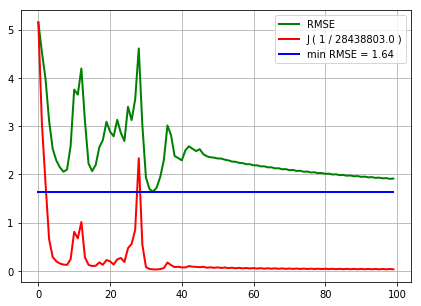

In [23]:
Jcut = np.round( max(l_J) / max(l_RMSE) ,0)
minRMSE = np.round( min(l_RMSE) ,2)
plt.figure(figsize=(7,5))
plt.plot( l_idx , l_RMSE , color = 'green' , linewidth = 2 , label='RMSE' )
plt.plot( l_idx , l_J / Jcut , color = 'red' , linewidth = 2 , label='J ( 1 / ' + str(Jcut) + ' )' )
plt.plot( (min(l_idx),max(l_idx)) , (minRMSE,minRMSE) , color = 'blue' , linewidth = 2 , label='min RMSE = ' + str(minRMSE) )
plt.grid( True )
plt.legend()
plt.show()

a1=[[1,2],[3,2],[5,2]];//列表
a2=array(a1);//将列表转换成二维数组
a3=array(a1);//将列表转化成矩阵
a4=array(a3);//将矩阵转换成数组
a5=a3.tolist();//将矩阵转换成列表
a6=a2.tolist();//将数组转换成列表

a1=[1,2,3];
a2=array(a1);
a3=mat(a1);
a4=a2.tolist();//这里得到的是[1,2,3]
a5=a3.tolist();//这里得到的是[[1,2,3]]
a6=(a4 == a5);//a6=False
a7=(a4 is a5[0]);//a7=True,a5[0]=[1,2,3]